In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano

from theano import tensor as tt
from scipy import stats

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [2]:
az.style.use("arviz-darkgrid")

# Chapter 10 - Memory retention
  
This Chapter is about estimating the relationship between memory retention and time.
The model being considered is a simplified version of the exponential decay model. The model assumes that the probability that an item will be remembered after a period of time $t$ has elapsed is $\theta_{t} = \text{exp}(−\alpha t)+\beta$, with the restriction $0 < \theta_{t} < 1$. The $\alpha$ parameter corresponds to the rate of decay of information. The $\beta$ parameter corresponds to a baseline level of remembering that is assumed to remain even after very long time periods.
  
## 10.1 No individual differences


$$ \alpha \sim \text{Beta}(1,1)$$
$$ \beta \sim \text{Beta}(1,1)$$
$$ \theta_{j} = \text{min}(1,\text{exp}(−\alpha t_{j})+\beta)$$
$$ k_{ij} \sim \text{Binomial}(\theta_{j},n)$$

In [3]:
cond = np.array([1, 2, 4, 7, 12, 21, 35, 59, 99, 200])
n_cond = len(cond)
# slist = [0,1,2,3]
n_sub = 4
cond_mat = np.repeat(cond, n_sub).reshape(n_cond, -1).T
data = np.ma.masked_values([18, 18, 16, 13, 9, 6, 4, 4, 4, -999,
                          17, 13,  9,  6, 4, 4, 4, 4, 4, -999,
                          14, 10,  6,  4, 4, 4, 4, 4, 4, -999,
                          -999, -999, -999, -999, -999, -999, -999, -999, -999, -999]
                           , value=-999).reshape(n_sub,-1)
n_trails = 18

print("Experiment is {}".format(cond_mat.shape))
print("Data are {}".format(data.shape))

Experiment is (4, 10)
Data are (4, 10)


In [72]:
with pm.Model() as model1:
    # prior
    alpha = pm.Beta("alpha", alpha=1, beta=1, testval=0.30)
    beta = pm.Beta("beta", alpha=1, beta=1, testval=0.25)

    # parameter transformation: asssumed psychophysical function 
    theta = tt.exp(-alpha * cond_mat) + beta
    # thetaj = pm.Deterministic('thetaj', tt.clip(theta, 0, 1))
    thetaj = pm.Deterministic("thetaj", tt.minimum(theta, 1))

    kij = pm.Binomial("kij", p=thetaj, n=n_trails, observed=data)

    step = pm.NUTS(target_accept=0.99)
    trace1 = pm.sample(2000, tune=2000, step=step)
    az.plot_trace(trace1, var_names=["alpha", "beta", "thetaj"], compact=True)

TypeError: Variables do not support boolean operations.

The above model is **very sensitive to the starting value**. We can **specify a starting value** for each parameter by assigning a `testval` when the RV is created:
```python
alpha = pm.Beta('alpha', alpha=1, beta=1, testval=.30)
```

In fact, with a bad starting value, NUTS really has a hard time sampling, and we get a `Bad initial energy` error. The reason is that bounding the theta gives 0 gradient, which is a problem as NUTS needs th gradient to work.

(0.0, 1.0)

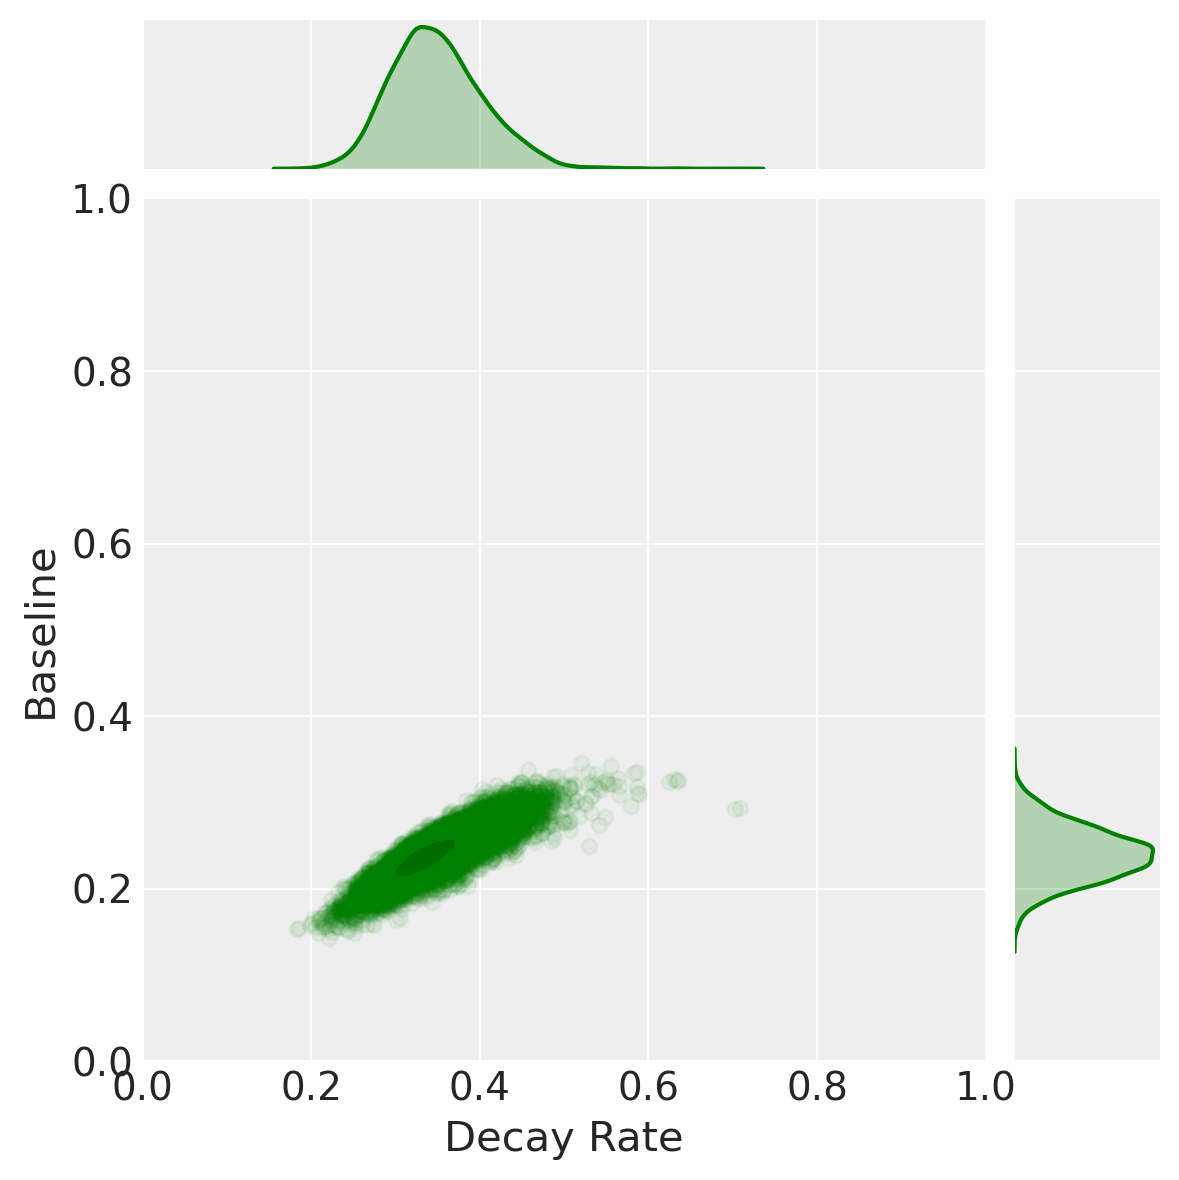

In [5]:
# reproduce Fig 10.2
# The joint and marginal posterior distributions over the decay and baseline parameters
alpha_x = trace1["alpha"]
beta_y = trace1["beta"]

joint_alpha_beta = np.vstack((alpha_x, beta_y))
joint_data = pd.DataFrame(joint_alpha_beta.transpose(), columns=["alpha", "beta"])

g = sns.jointplot(x="alpha", y="beta", data=joint_data, kind="kde", 
                  color="g", stat_func=None, xlim=(0, 1), ylim=(0, 1))
g.plot_joint(plt.scatter, c="g", s=30, linewidth=1, alpha=0.05)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Decay Rate", "Baseline")
plt.xlim(0, 1)
plt.ylim(0, 1)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 814.27it/s]


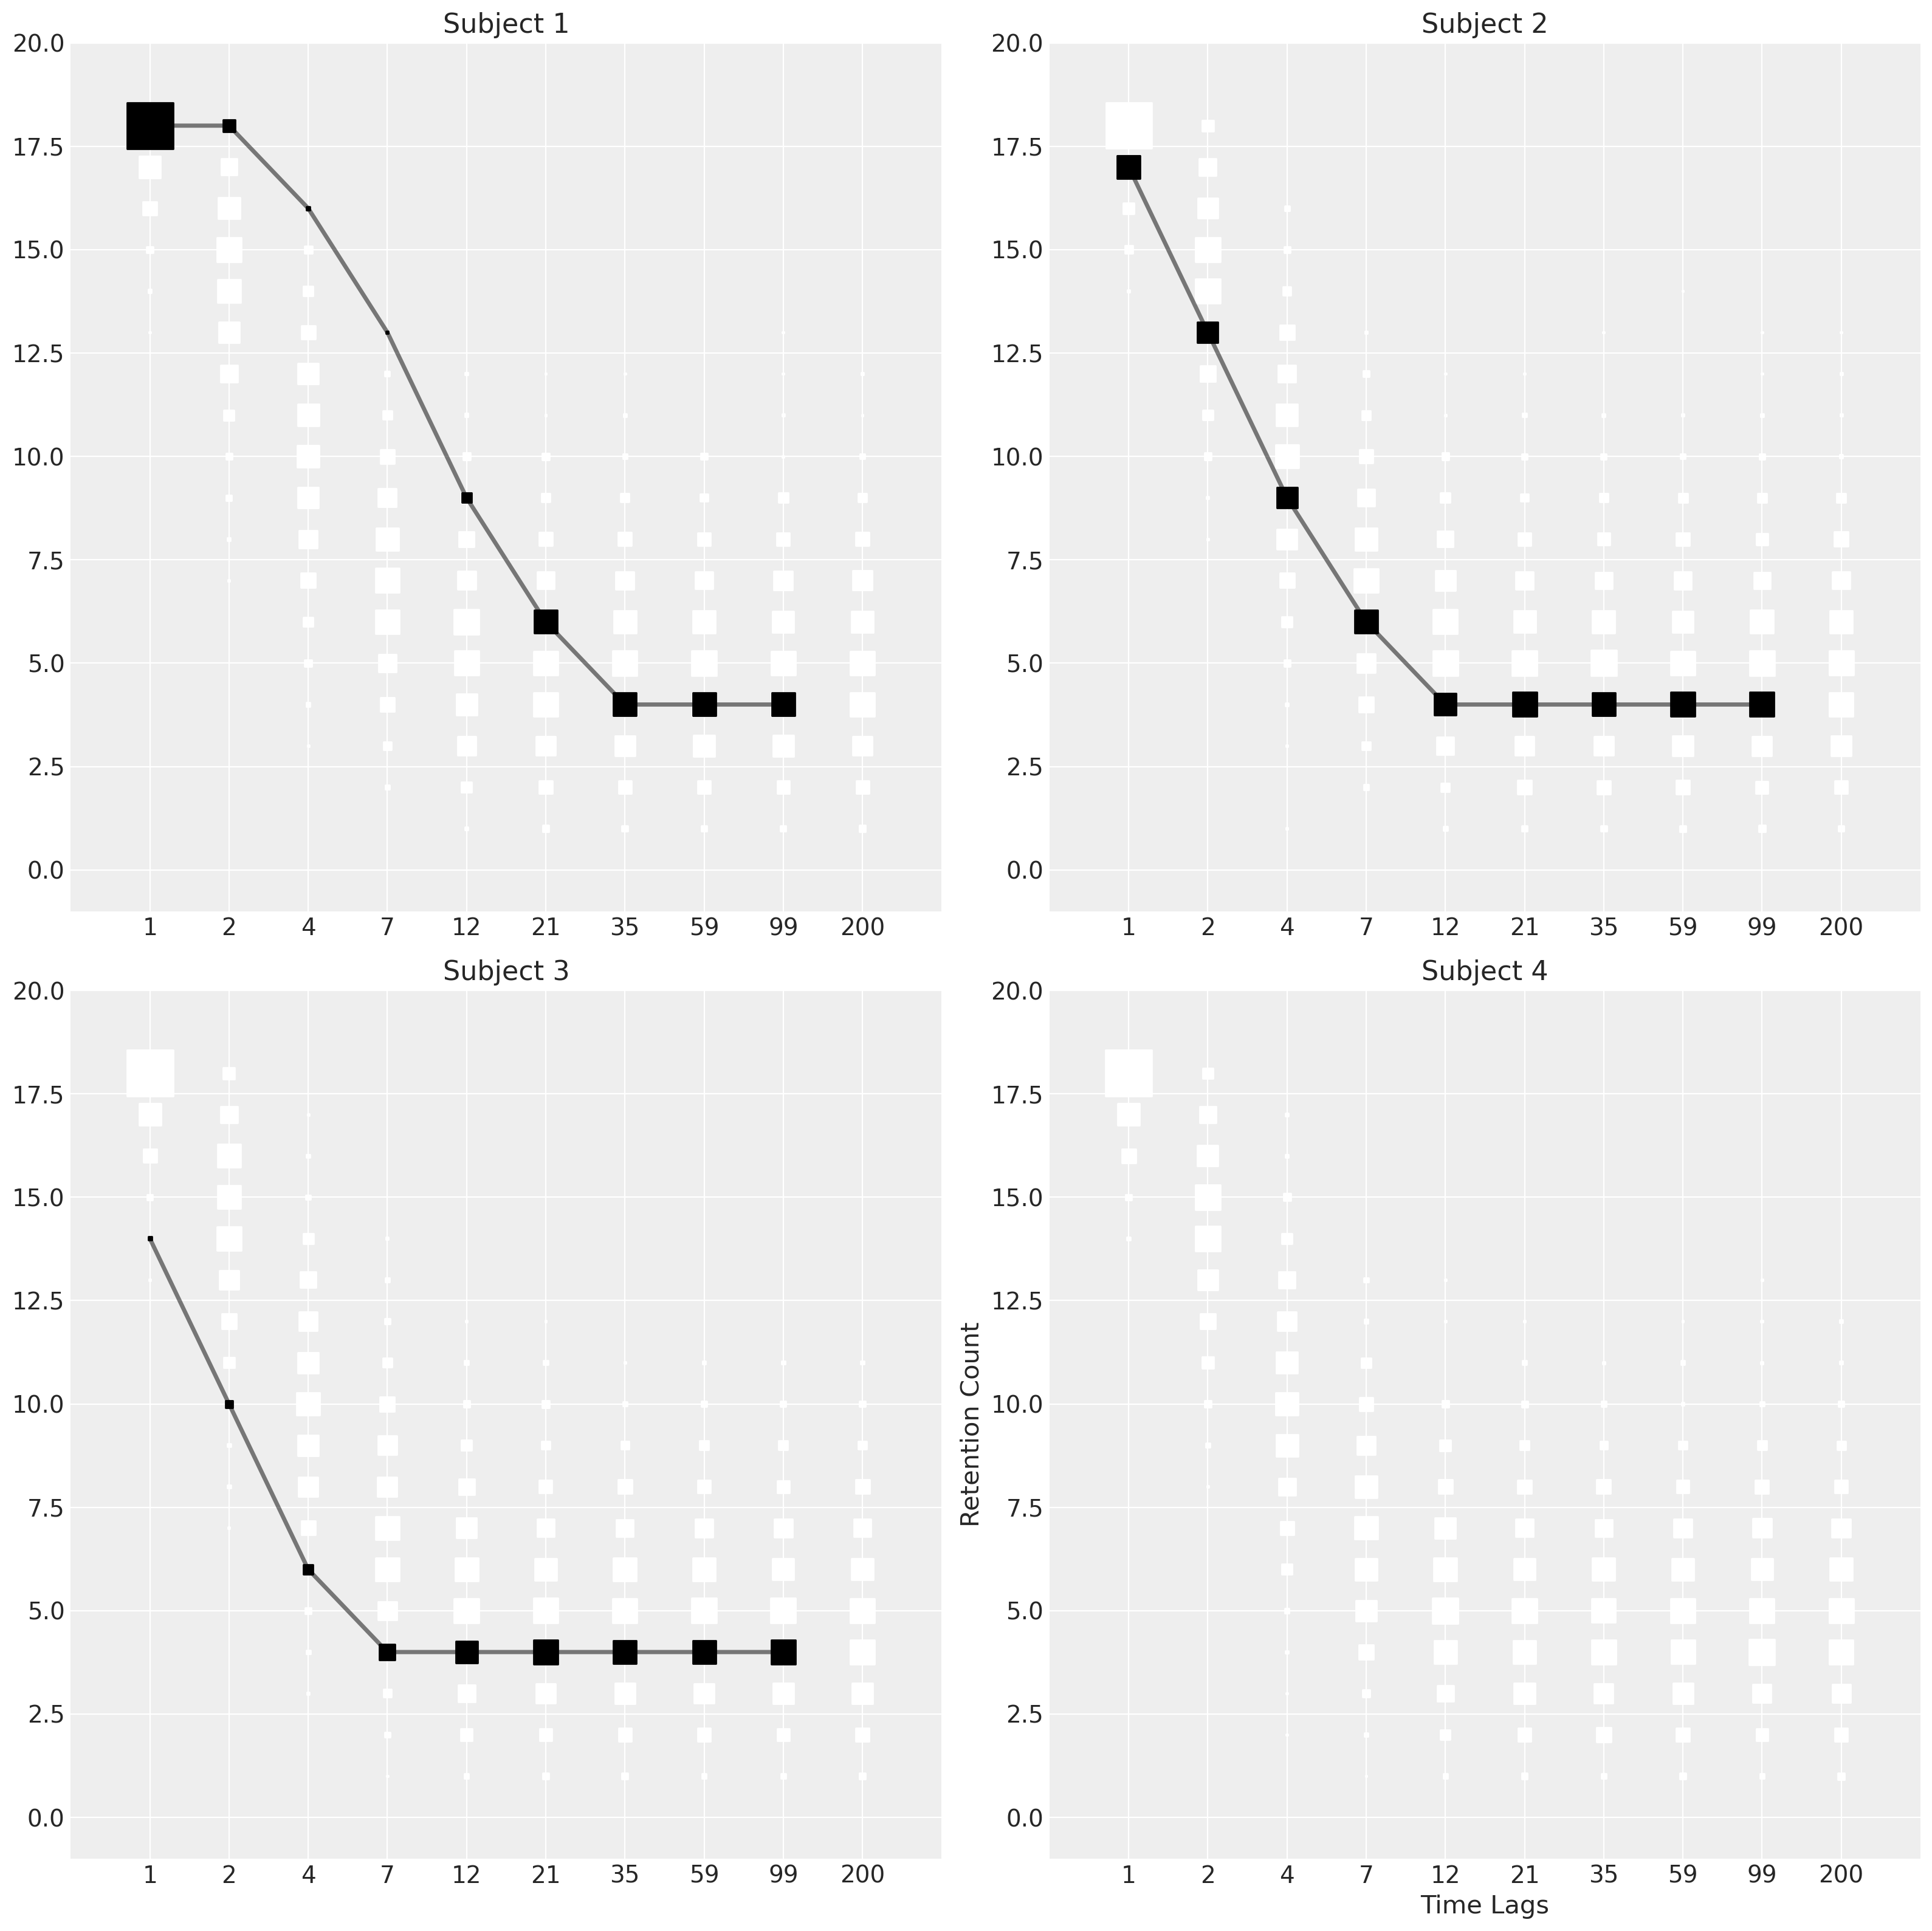

In [16]:
# reproduce Fig 10.3
# The posterior predictive distribution for the model that assumes no individual differences.

# we use data to estimate parameters, and use these parameters to build posterior
# then we generate posterior predictive samples from this model given the trace
ppc = pm.sample_posterior_predictive(trace1, model=model1, samples=1000)
predict_trace = ppc["kij"]


def plot_predict(predictrace, data):
    _, n_sub, n_cond = predictrace.shape
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    bins = np.arange(0, n_trails + 1) # n: num of trials in one condition, 18
    ax = axes.flatten() # (2, 2) -> (4, 1)
    
    for i_sub in range(n_sub): # iterate through subject 
        sub_pred = np.squeeze(predict_trace[:, i_sub, :])
        n_ax = ax[i_sub]
        
        for i_cond in range(n_cond): # iterate through condition
            bin_height, bin_idx = np.histogram(sub_pred[:, i_cond], bins=bins, normed=True)
            n_ax.scatter(i_cond * np.ones(bins.size - 1), bin_idx[1:], s=bin_height * 1000, c="w", marker="s")
            

            if (data[i_sub, i_cond] is np.ma.masked) == 0:
                n_ax.scatter(i_cond, data[i_sub, i_cond], s=bin_height[data[i_sub, i_cond] - 1] * 1000, c="k", marker="s")
                
        n_ax.plot(np.arange(len(cond)), data[i_sub, :], "k", lw=2.5, alpha=0.5)
        n_ax.set_xlim(-1, 10)
        n_ax.set_ylim(-1, 20)
        n_ax.set_title("Subject %s" % (i_sub + 1))
        
    plt.setp(axes, xticks=np.arange(len(cond)), xticklabels=cond)
    plt.xlabel("Time Lags")
    plt.ylabel("Retention Count")
    plt.tight_layout()
    
plot_predict(predict_trace, data)          

## 10.2 Full individual differences


$$ \alpha_{i} \sim \text{Beta}(1,1)$$
$$ \beta_{i} \sim \text{Beta}(1,1)$$
$$ \theta_{ij} = \text{min}(1,\text{exp}(−\alpha_{i} t_{j})+\beta_{i})$$
$$ k_{ij} \sim \text{Binomial}(\theta_{ij},n)$$

In [8]:
cond = np.array([1, 2, 4, 7, 12, 21, 35, 59, 99, 200])
n_cond = len(cond)
# slist = [0,1,2,3]
n_sub = 4
cond_mat = np.repeat(cond, n_sub).reshape(n_cond, -1).T
data = np.ma.masked_values([18, 18, 16, 13, 9, 6, 4, 4, 4, -999,
                          17, 13,  9,  6, 4, 4, 4, 4, 4, -999,
                          14, 10,  6,  4, 4, 4, 4, 4, 4, -999,
                          -999, -999, -999, -999, -999, -999, -999, -999, -999, -999]
                           , value=-999).reshape(n_sub,-1)
n_trails = 18

In [82]:
with pm.Model() as model2:
    alpha = pm.Beta("alpha", alpha=1, beta=1, shape=(n_sub, 1), 
                    testval=np.asarray([0.3, 0.3, 0.3, 0.5]).reshape(n_sub, 1))
    beta = pm.Beta("beta", alpha=1, beta=1, shape=(n_sub, 1), 
                   testval=np.asarray([0.25, 0.25, 0.25, 0.5]).reshape(n_sub, 1))
    #theta = tt.exp(-alpha * cond_mat) + beta
    theta = tt.exp(tt.tile(-alpha, n_cond) * cond_mat) + tt.tile(beta, n_cond)
    thetaj = pm.Deterministic("thetaj", tt.minimum(theta, 1))

    kij = pm.Binomial("kij", p=thetaj, n=n_trails, observed=data)

In [ ]:

    # generate ppc
    theta2 = tt.minimum(tt.exp(tt.tile(-alpha, n_cond) * cond_mat) + tt.tile(beta, n_cond).T, 1.0)
    rng = tt.shared_randomstreams.RandomStreams()
    kij_ppc = pm.Deterministic("kij_ppc", rng.binomial(n=n, p=theta2))

Due to the difficulty of the model as explained above, here I do inference using fullrank_advi. The result seems quite comparable to JAGS actually.

In [83]:
with model2:
    # ADVI
    s = theano.shared(pm.floatX(1))
    inference = pm.FullRankADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace2 = approx.sample(3000, include_transformed=True)

    elbos1 = -inference.hist

Average Loss = inf: 100%|███████████████████████████████████████████████████████| 20000/20000 [00:21<00:00, 936.63it/s]
Finished [100%]: Average Loss = 74.699
Average Loss = inf: 100%|██████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1036.97it/s]
Finished [100%]: Average Loss = 77.488


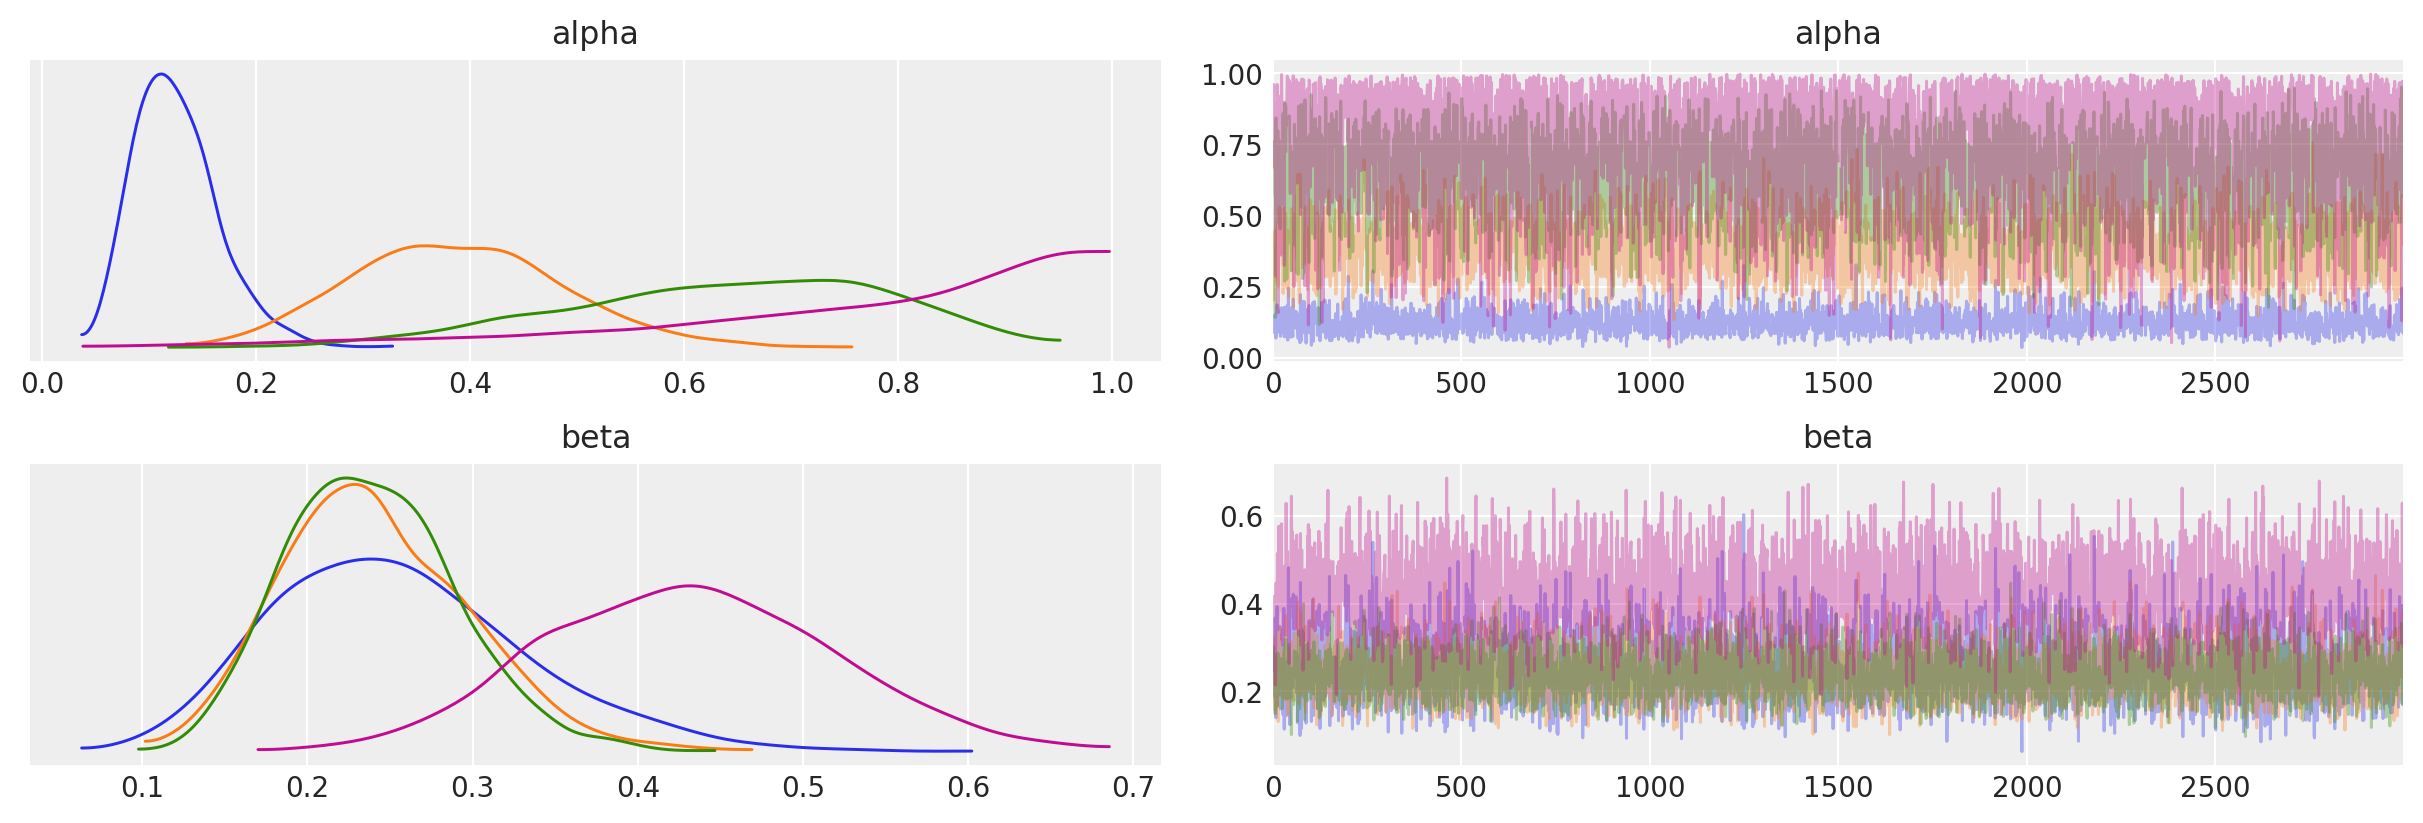

In [84]:
az.plot_trace(trace2, var_names=["alpha", "beta"], compact=True);

In [85]:
# reproduce Fig 10.5
def scatter_alpha_beta(trace):
    from matplotlib.ticker import NullFormatter

    nullfmt = NullFormatter()  # no labels
    xtrace = trace["alpha"][:1000].squeeze()
    ytrace = trace["beta"][:1000].squeeze()
    ns_ = xtrace.shape[1]

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # now determine limits by hand:
    binwidth1 = 0.25

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))

    cc = ["C0", "C1", "C2", "C3"]

    for iss in np.arange(ns_):
        x = xtrace[:, iss]
        y = ytrace[:, iss]

        axScatter = plt.axes(rect_scatter)
        axScatter.set_xlim((0, 1))
        axScatter.set_ylim((0, 1))

        axHistx = plt.axes(rect_histx)
        axHisty = plt.axes(rect_histy)

        # no labels
        axHistx.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)

        # the scatter plot:
        axScatter.scatter(x, y, c=cc[iss], alpha=0.1)
        axScatter.set_xlabel("Decay Rate", fontsize=18)
        axScatter.set_ylabel("Baseline", fontsize=18)

        bins1 = np.linspace(0, 1, 50)
        axHistx.hist(x, bins=bins1, color=cc[iss], alpha=0.5, normed=True)
        bins2 = np.linspace(0, 1, 50)
        axHisty.hist(
            y,
            bins=bins2,
            color=cc[iss],
            alpha=0.5,
            normed=True,
            orientation="horizontal",
        )

        axHistx.set_xlim(axScatter.get_xlim())
        axHisty.set_ylim(axScatter.get_ylim())

    plt.tight_layout();

However, fitting using NUTS will give bias/different estimation compare to JAGS (same thing happens in [STAN](https://github.com/stan-dev/example-models/blob/master/Bayesian_Cognitive_Modeling/CaseStudies/MemoryRetention/Retention_2_Stan.R#L6))

AttributeError: 'Rectangle' object has no property 'normed'

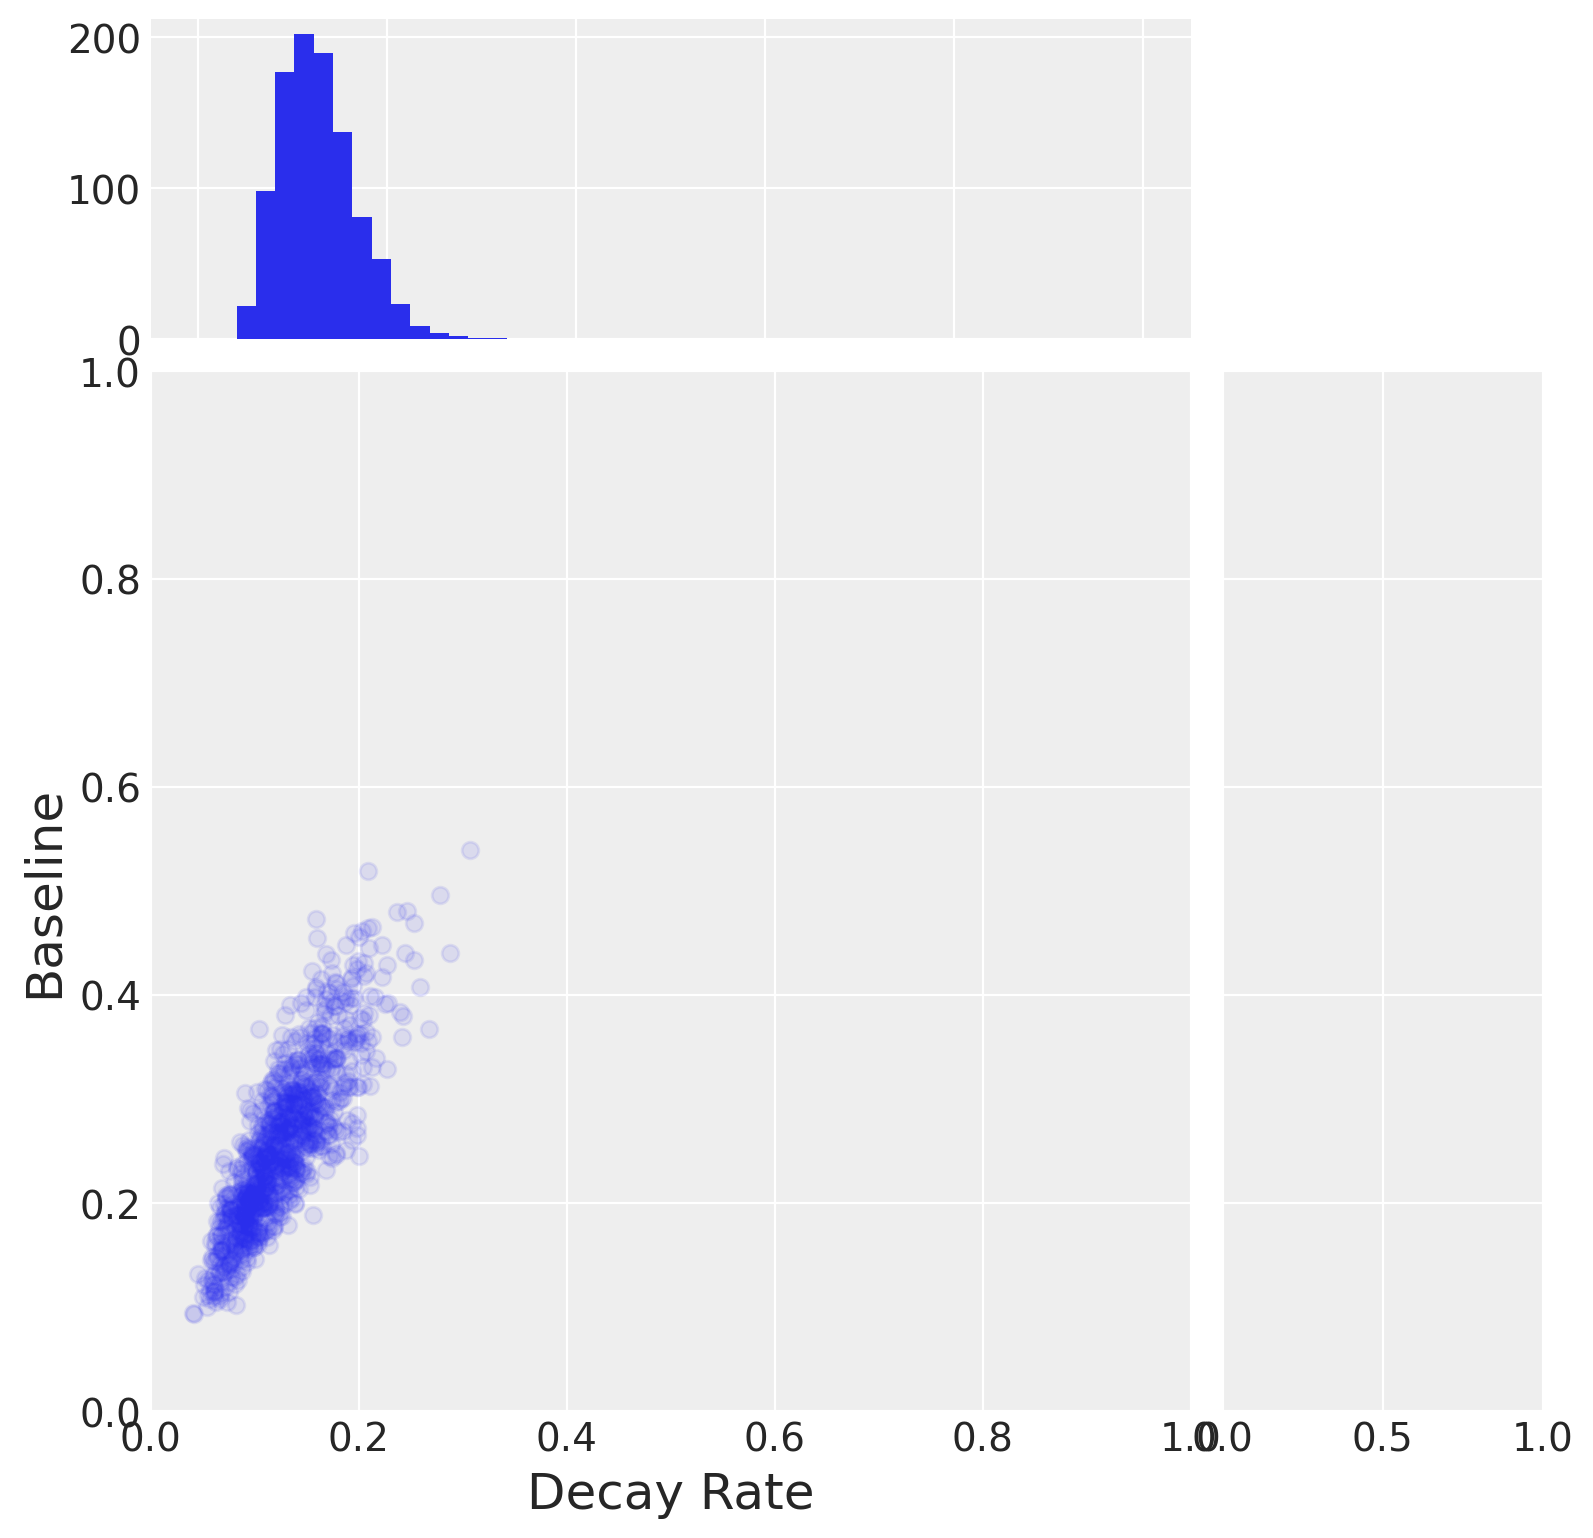

In [87]:
scatter_alpha_beta(trace2)

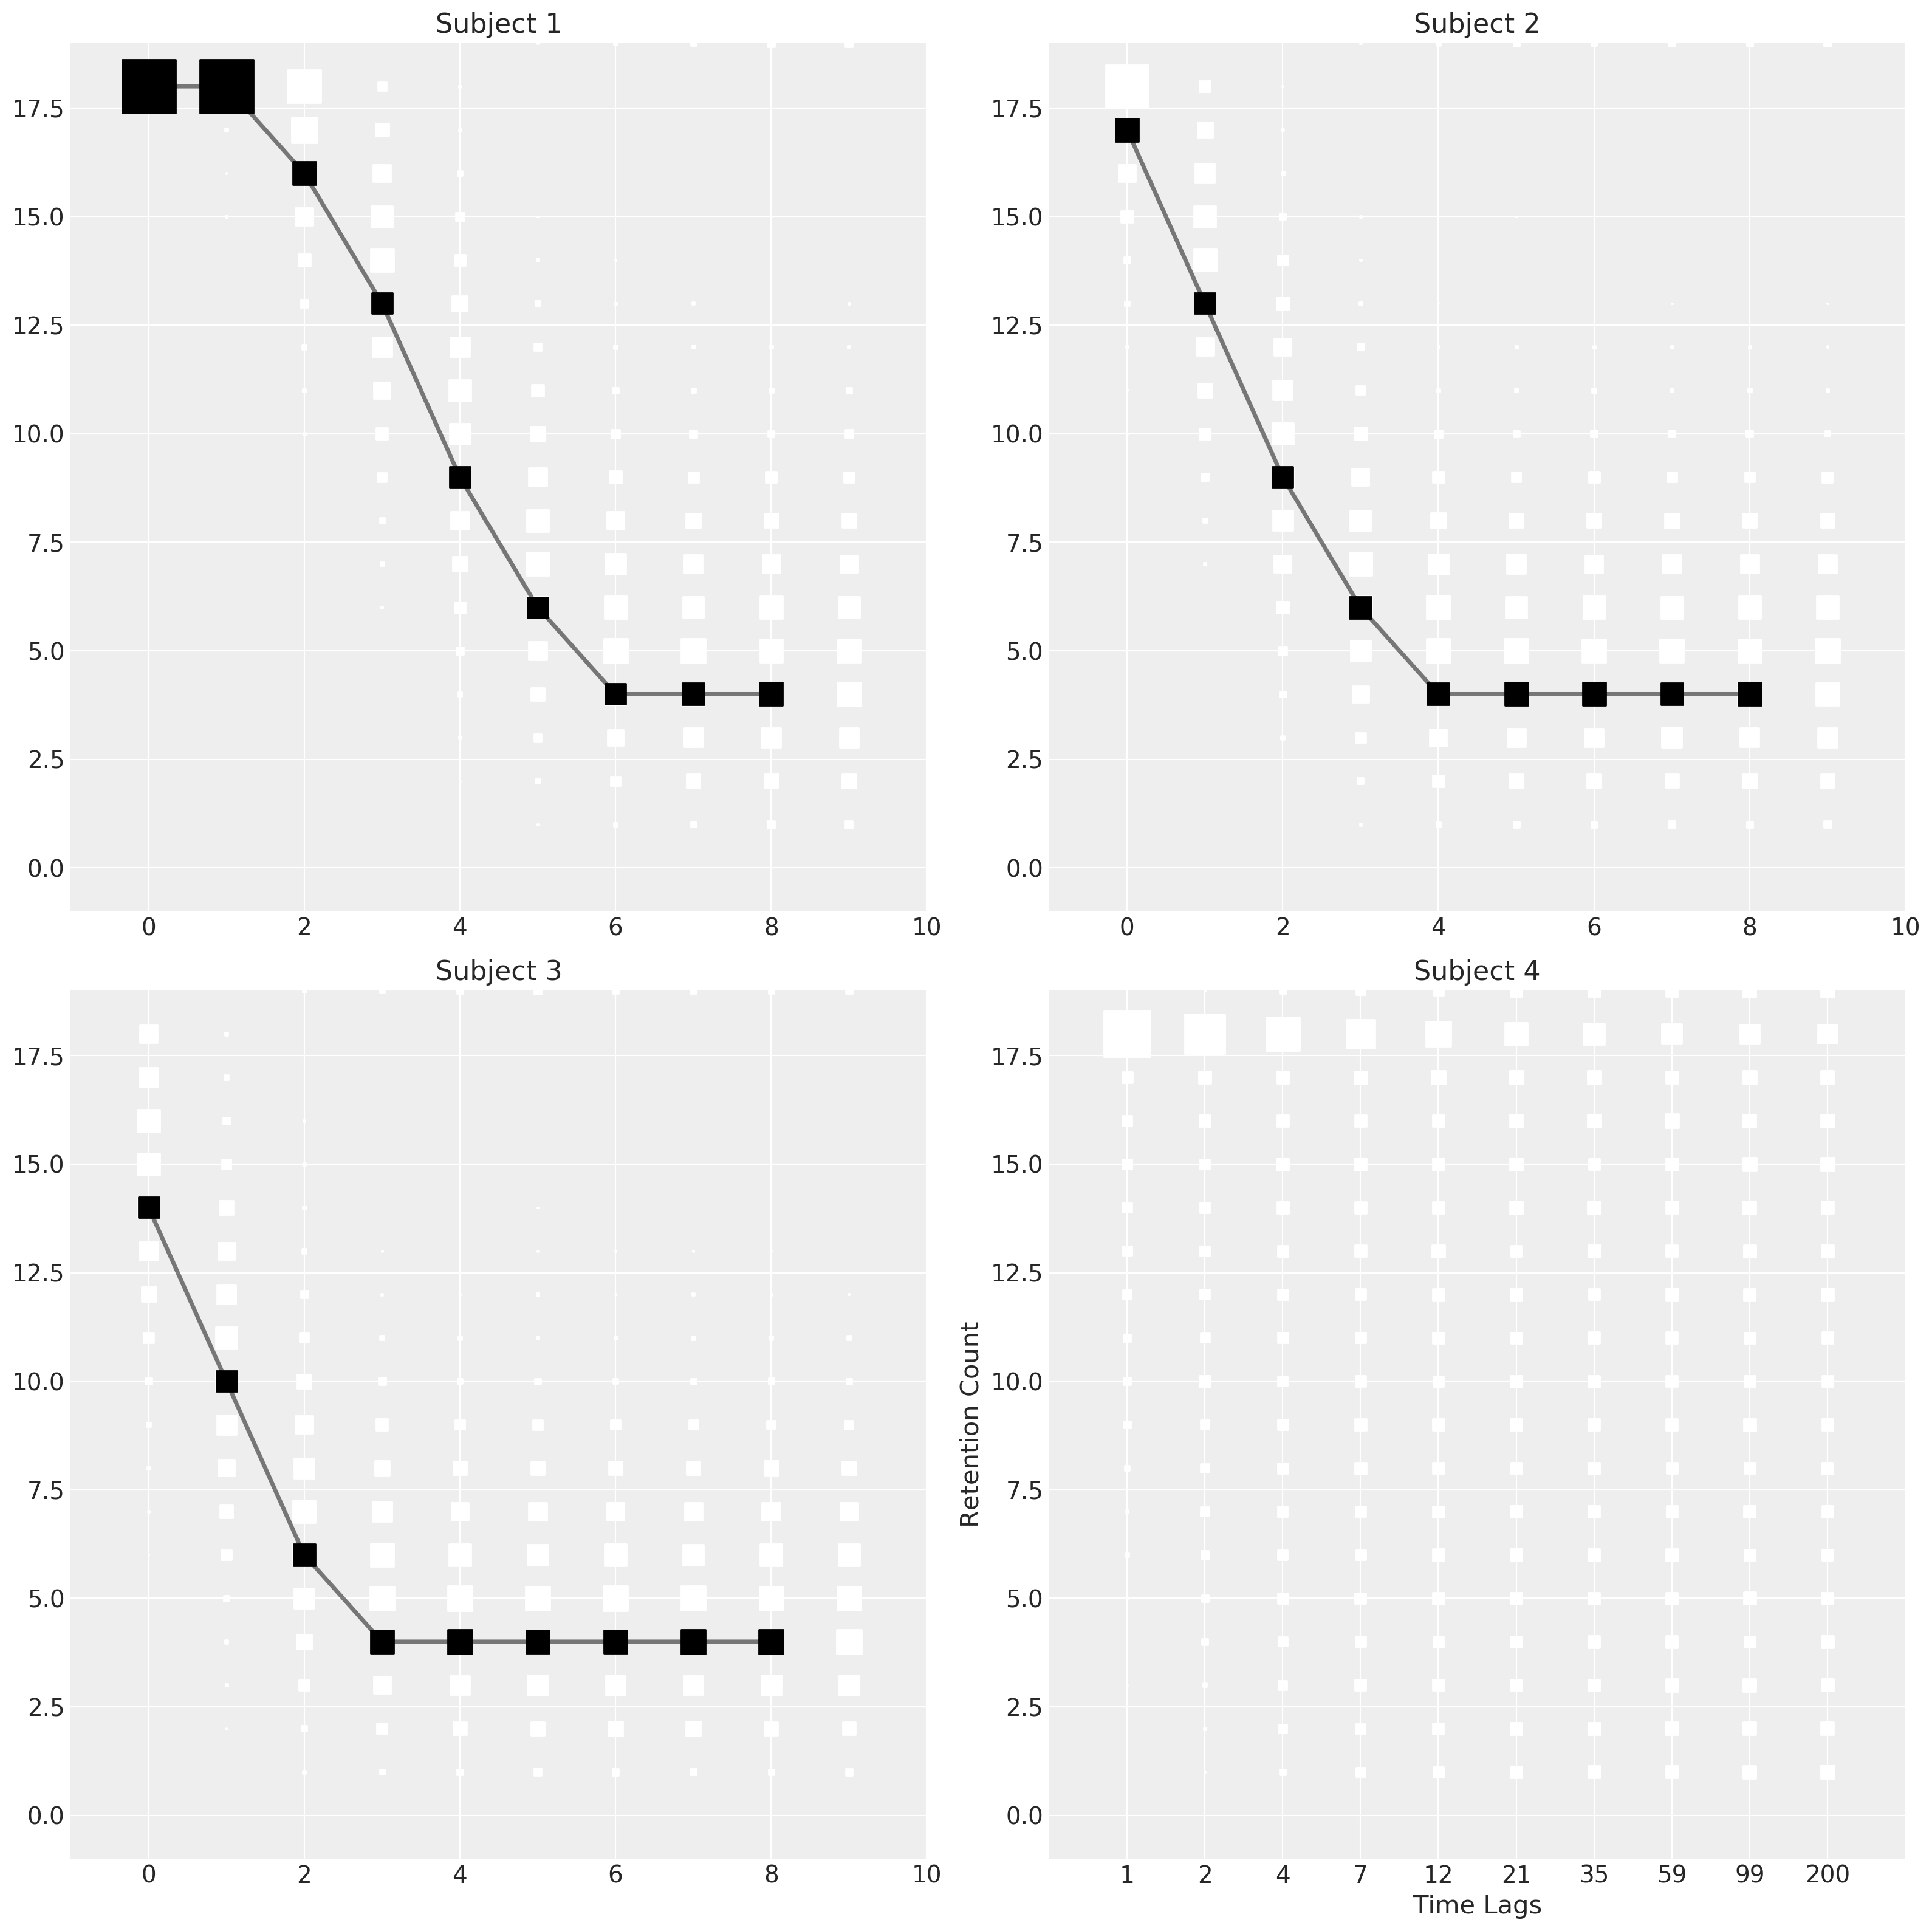

In [16]:
# reproduce Fig 10.3
# The posterior predictive distribution for the model that assumes no individual
# differences.
plot_predict(trace2_["kij_ppc"])

## 10.3 Structured individual differences


$$ \mu_{\alpha} \sim \text{Beta}(1,1)$$
$$ \lambda_{\alpha} \sim \text{Gamma}(.001,.001)$$
$$ \mu_{\beta} \sim \text{Beta}(1,1)$$
$$ \lambda_{\beta} \sim \text{Gamma}(.001,.001)$$
$$ \alpha_{i} \sim \text{Gaussian}(\mu_{\alpha}, \lambda_{\alpha})_{\mathcal I(0,1)} $$
$$ \beta_{i} \sim \text{Gaussian}(\mu_{\beta}, \lambda_{\beta})_{\mathcal I(0,1)} $$
$$ \theta_{ij} = \text{min}(1,\text{exp}(−\alpha_{i} t_{j})+\beta_{i})$$
$$ k_{ij} \sim \text{Binomial}(\theta_{ij},n)$$

Finished [100%]: Average Loss = 64.292


Finished [100%]: Average Loss = 63.407


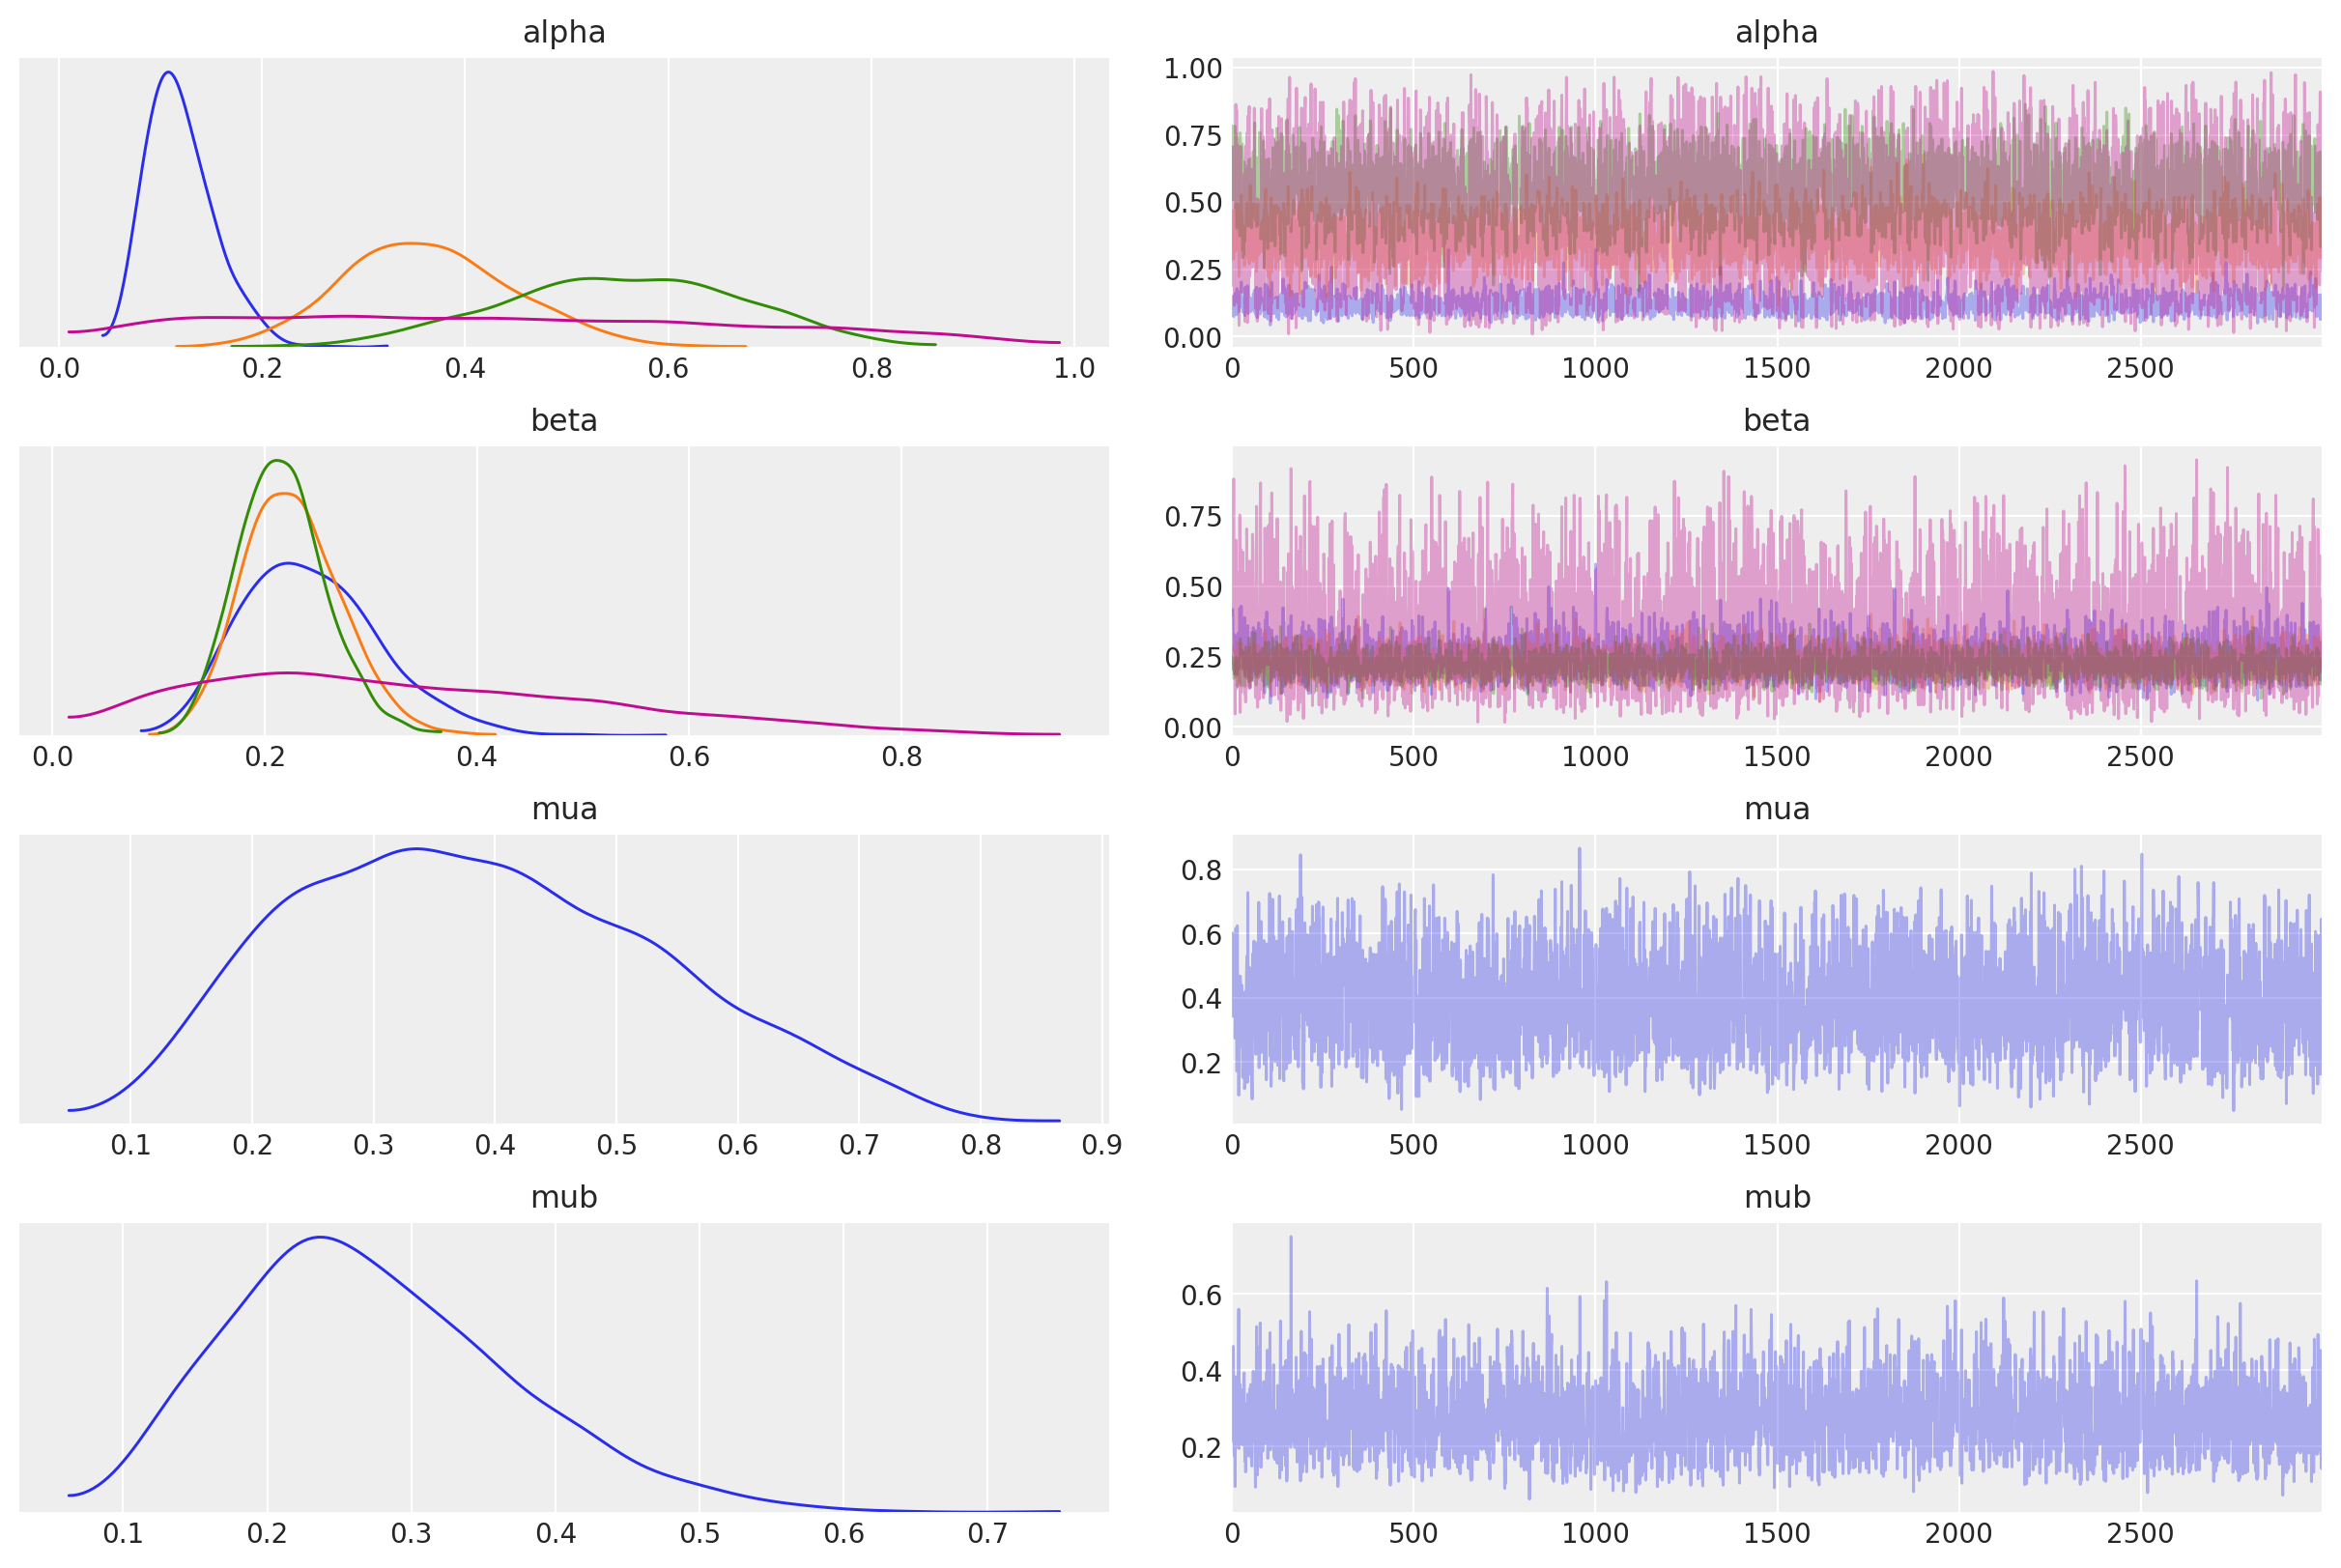

In [17]:
BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
with pm.Model() as model3:
    mua = pm.Beta("mua", alpha=1, beta=1)
    lambdaa = pm.Gamma("lambdaa", alpha=0.001, beta=0.001)
    mub = pm.Beta("mub", alpha=1, beta=1)
    lambdab = pm.Gamma("lambdab", alpha=0.001, beta=0.001)

    alpha = BoundedNormal("alpha", mu=mua, tau=lambdaa, shape=(1, ns))
    beta = BoundedNormal("beta", mu=mub, tau=lambdab, shape=(1, ns))

    theta = (tt.exp(-alpha[:, :ns2] * t2[:, None]) + beta[:, :ns2]).T
    thetaj = pm.Deterministic("thetaj", tt.minimum(theta, 1))

    kij = pm.Binomial("kij", p=thetaj, n=n, observed=k2)

    # generate ppc
    theta2 = tt.minimum((tt.exp(-alpha * t[:, None]) + beta).T, 1.0)
    rng = tt.shared_randomstreams.RandomStreams()
    kij_ppc = pm.Deterministic("kij_ppc", rng.binomial(n=n, p=theta2))

    # step = pm.NUTS(target_accept=.99)
    # trace3_ = pm.sample(1e4, tune=1000, init='advi', njobs=2)

    # ADVI
    s = theano.shared(pm.floatX(1))
    inference = pm.FullRankADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace3_ = approx.sample(3000)

    elbos1 = -inference.hist

az.plot_trace(trace3_, var_names=["alpha", "beta", "mua", "mub"], compact=True);

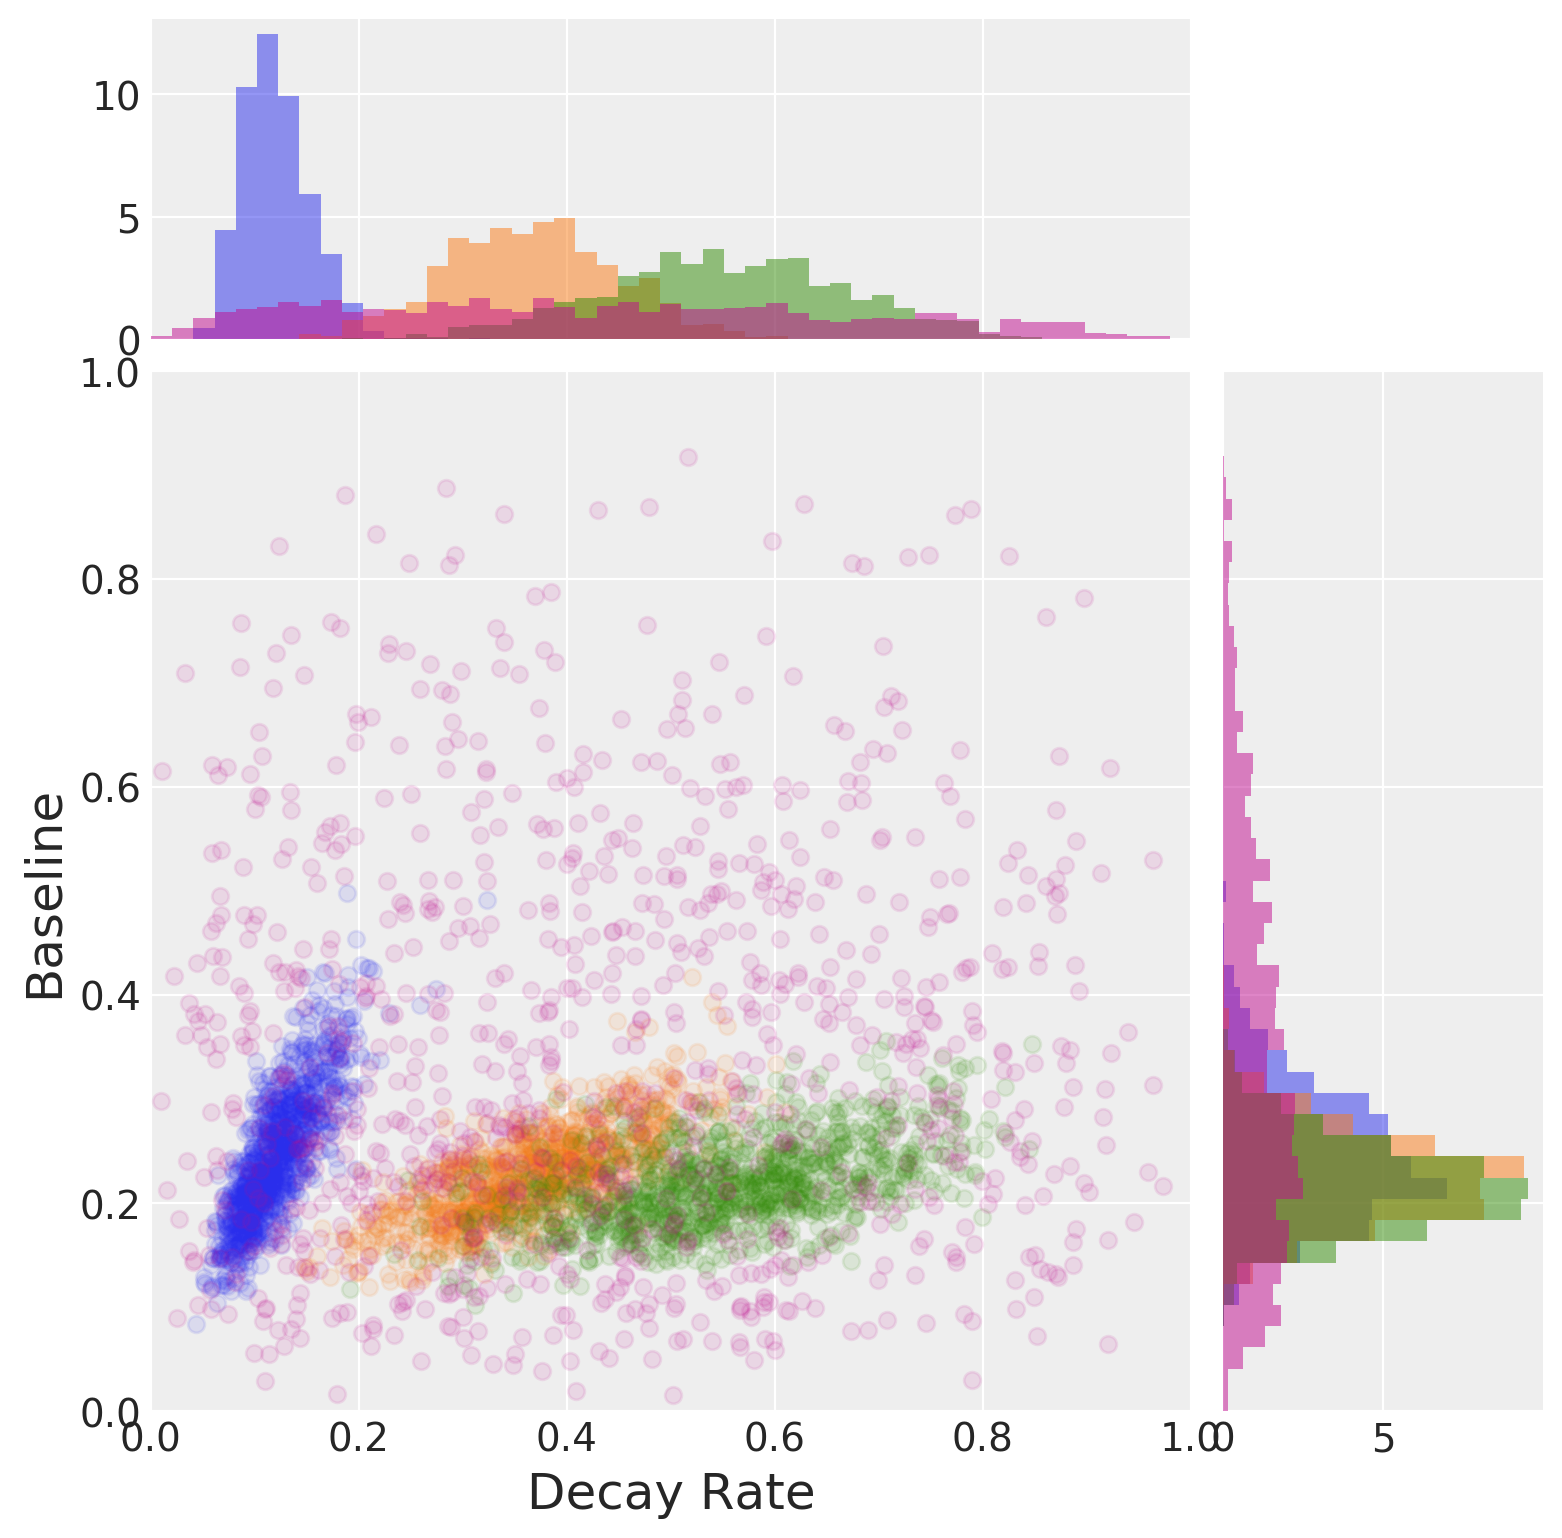

In [18]:
scatter_alpha_beta(trace3_)

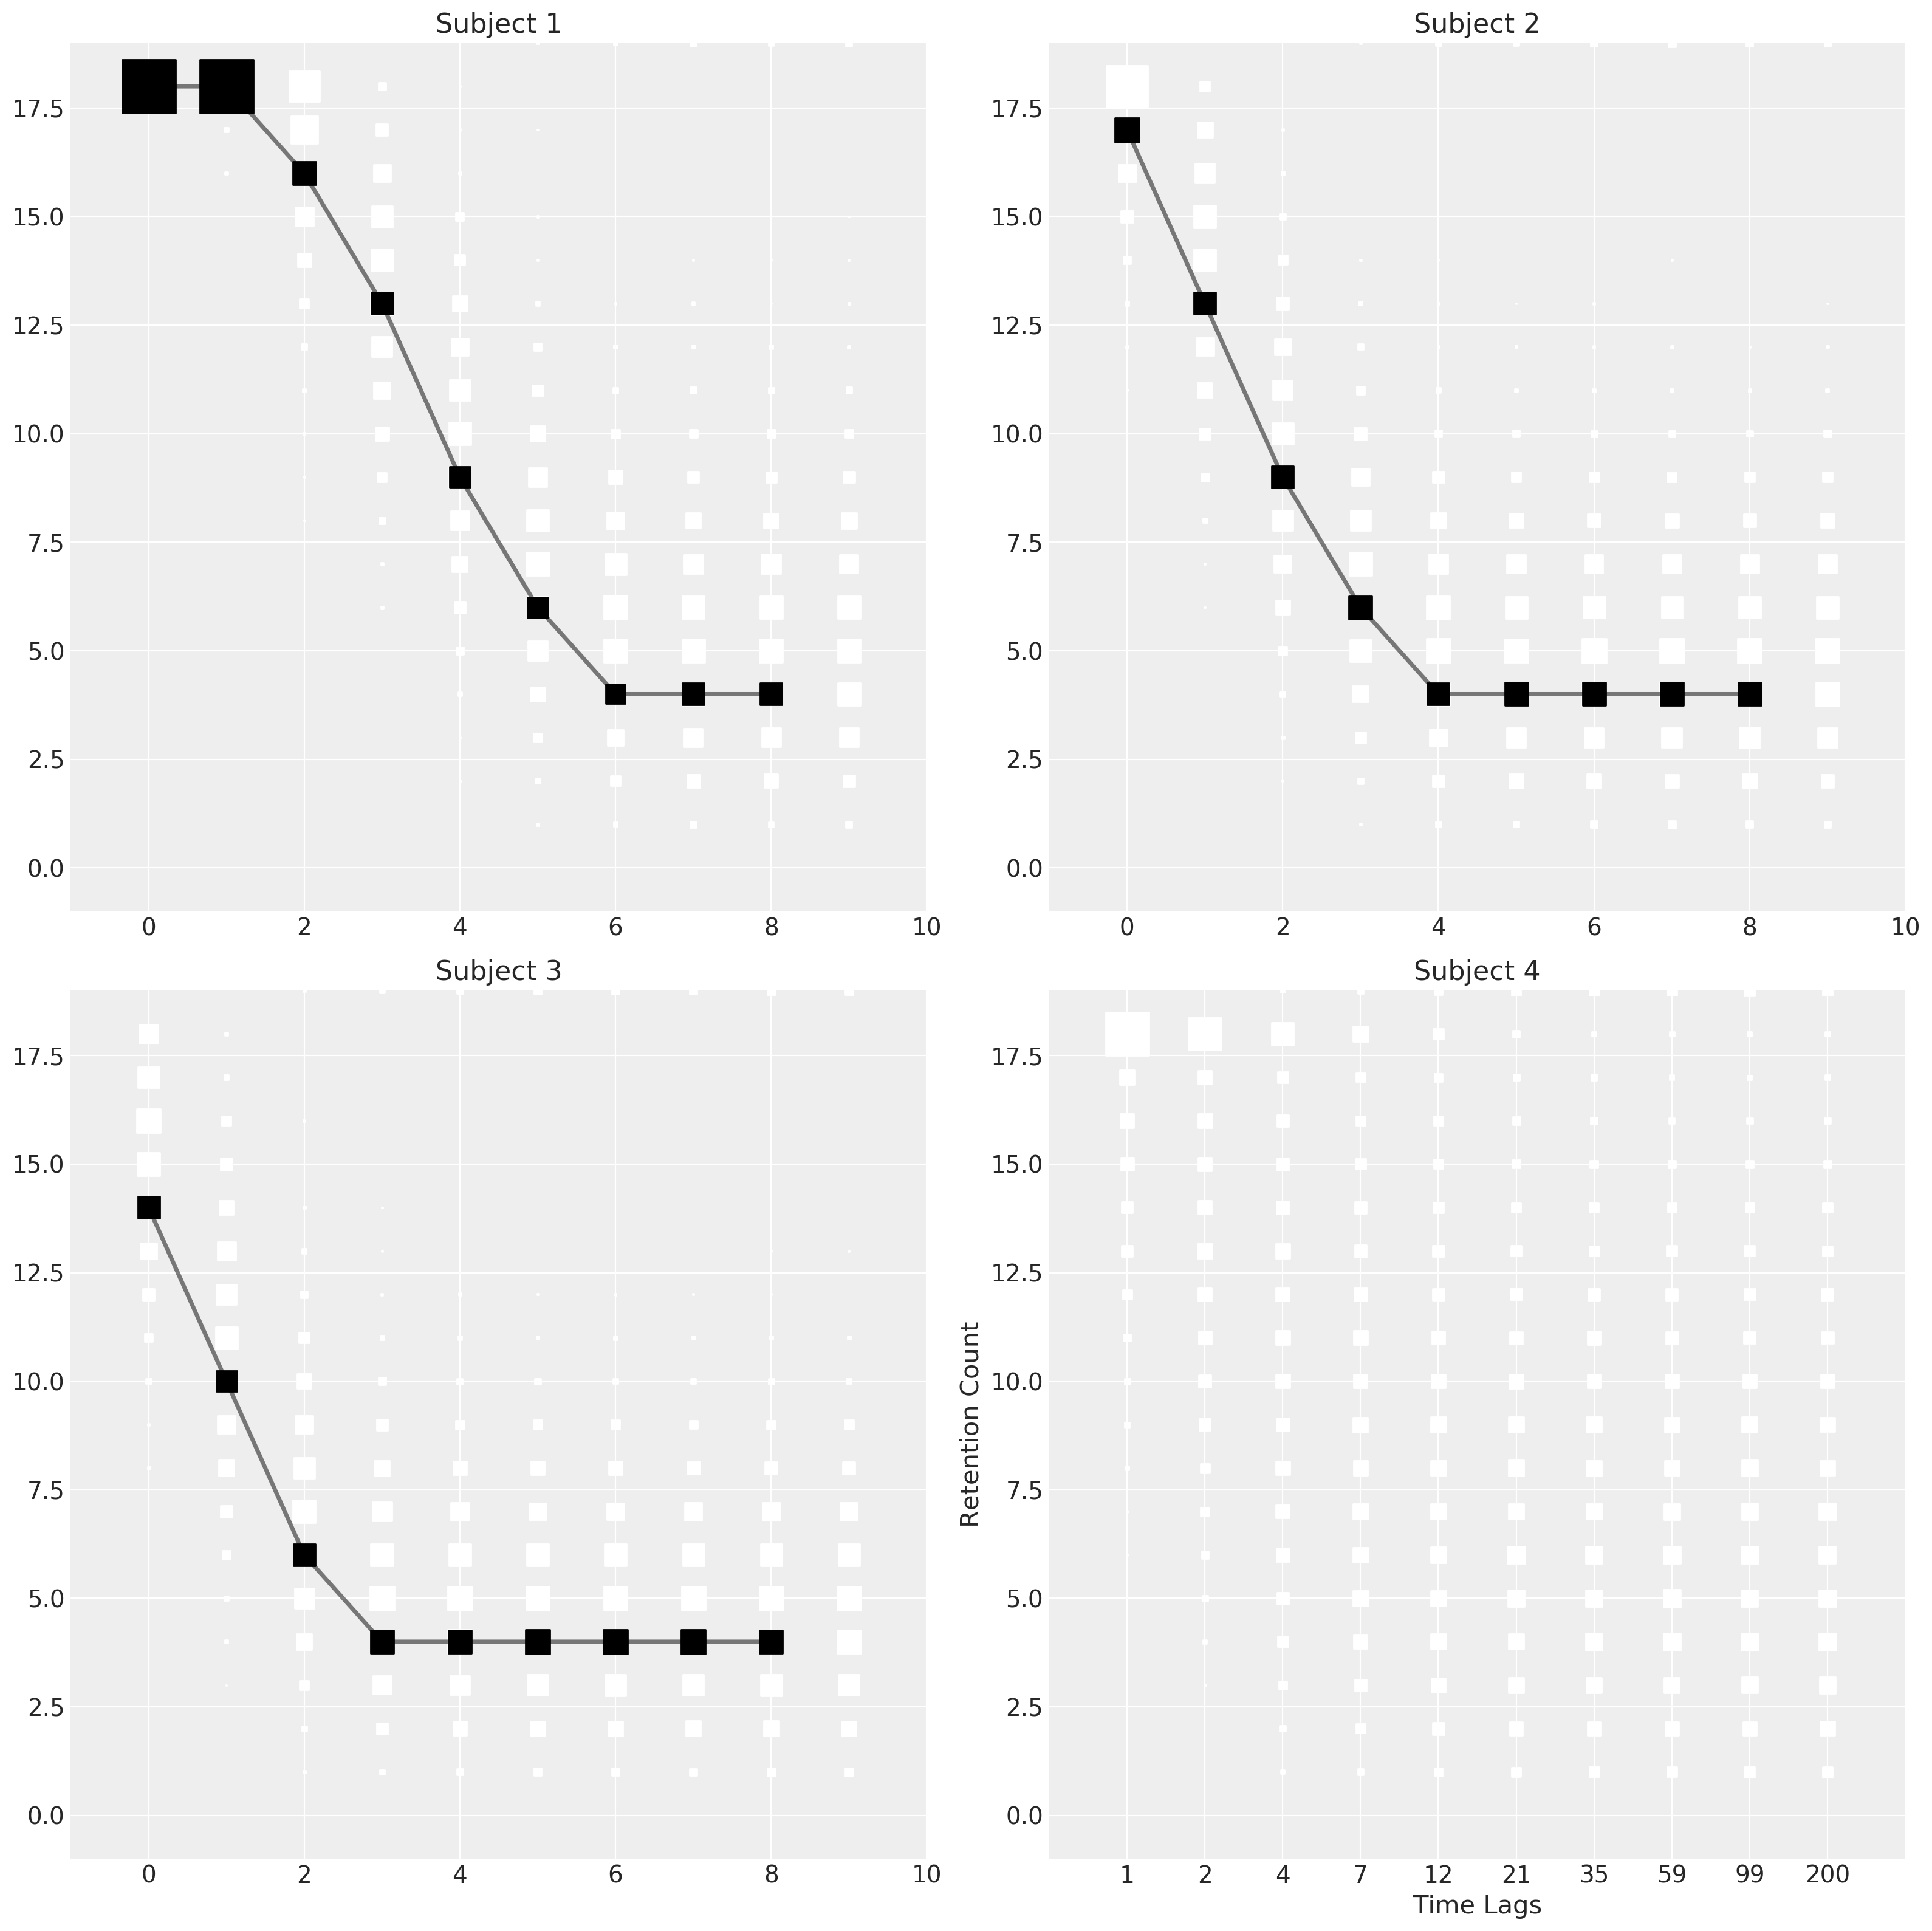

In [19]:
plot_predict(trace3_["kij_ppc"])